In [1]:
#TODO insert only needed package

import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision.transforms import Compose, ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch import nn

from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files
from fastai.data.core import DataLoaders
import PIL

import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from IPython import display

import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

#LOSS
!pip install torchmetrics
!pip install lpips

from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 40.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 KB 7.2 MB/s eta 0:00:00


###DATASET CREATION

In [2]:
path = untar_data(URLs.COCO_SAMPLE) 
coco_path = str(path) + "/train_sample" 

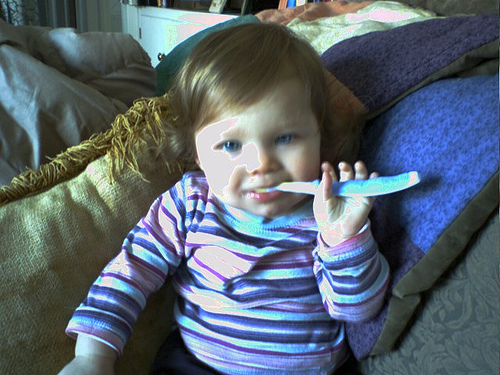

In [3]:
dataset = get_image_files(coco_path)   
img = PIL.Image.open(dataset[1])
img

In [4]:
print("INFO DATASET:")
print("Lunghezza: ", len(dataset))
print("Dimensioni immagini: ", img.size)

INFO DATASET:
Lunghezza:  21837
Dimensioni immagini:  (500, 375)


In [5]:
'''
@param fname image file name in the dataset
@param size size for the final image after resizing
@return Tensor representation of the image
'''
def open_resize_image(fname, size=256): 
    img = PIL.Image.open(fname)
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [6]:
open_resize_image(dataset[0]).shape

torch.Size([3, 256, 256])

In [7]:
paths = glob.glob(coco_path+"/*.jpg")                                # paths is a list with all image files names of the COCO dataset
np.random.seed(123)                                                  # Seeding for reproducible results
paths_subset = np.random.choice(paths, 10000, replace=False)         # Randomly choosing 10,000 images (image file names) from the list
rand_idxs = np.random.permutation(10000)                             # Shuffling the indexes
train_idxs = rand_idxs[:8000]                                        # Using first 8000 images for training
test_idxs = rand_idxs[8000:]                                         # Using last 2000 images for testing
train_paths = paths_subset[train_idxs]                               # Array with all the image files names for the training
test_paths = paths_subset[test_idxs]                                   # Array with all the image files names for the validation
print(len(train_paths), len(test_paths))

8000 2000


In [8]:
SIZE= 256
class CustomDataset(Dataset):

    def __init__(self, paths, transform, training_mode=True):
        self.paths = paths
        self.size = SIZE
        self.training_mode = training_mode

        if training_mode:
          self.transform = transform
        else:
          #simple resize to the SIZE x SIZE dimensions
          self.transform = Compose([
              transforms.Resize((SIZE,SIZE), Image.BICUBIC),
          ])

    def __getitem__(self, index):
        #open the image as an RGB image and apply the correct transformations and transform to numpy array
        img = Image.open(self.paths[index]).convert("RGB")
        img = self.transform(img)
        img = np.array(img)

        #converting RGB to L*a*b color space used for the task and then to a tensor
        img_lab = rgb2lab(img).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
        
    def __len__(self): 
      return len(self.paths)
 


In [9]:
#define the train, validation and test dataset and the batch size
batch_size = 16

train_transform = transforms.Compose([
     transforms.Resize((SIZE,SIZE), Image.BICUBIC),
])

train_dataset =  CustomDataset(train_paths, train_transform, training_mode = True)
test_dataset =  CustomDataset(test_paths, transform = None, training_mode = False)
#test_dataset =  ImageDataset("./", "test", ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [10]:
data = next(iter(train_dataloader))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dataloader), len(test_dataloader))
type(data['L'])

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


torch.Tensor

###UNET AND PATCH DISCRIMINATOR MODELS DEFINITION

In [11]:
import torch
import torch.nn as nn


""" DoubleConvBlock:
    It consists in a double 3x3 convolutional layer, each followed by a batch normalization layer and a relu activation.
"""
class DoubleConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
  
  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x) 
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x) 
    x = self.relu(x)
    return x


""" Encoder block:
    It consists of an doubleConvBlock followed by a max pooling layer.
    Here the number of filters doubles, the height and width half after every block.
"""
class EncoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.doubleConv = DoubleConvBlock(in_channels, out_channels)
    self.maxPool = nn.MaxPool2d((2, 2))
  
  def forward(self, inputs):
    x = self.doubleConv(inputs)
    p = self.maxPool(x)
    return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convTransp = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.doubleConv = DoubleConvBlock(out_channels+out_channels, out_channels)
        
    def forward(self, inputs, skip):
      x = self.convTransp(inputs)
      x = torch.cat([x, skip], axis=1)
      x = self.doubleConv(x)
      return x

""" UNet:
    The Unet class contains sequential EncoderBlock and DecoderBlock separated 
    by a Bottleneck layer, finally there is a simple Classification layer with 
    our output's size
"""
class Unet(nn.Module):
    def __init__(self, input_channels=1, output_channels=2):
        super().__init__()
        """ Encoder """
        self.enc1 = EncoderBlock(input_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)
        """ Bottleneck """
        self.bottleneck = DoubleConvBlock(512, 1024)
        """ Decoder """
        self.dec1 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, output_channels, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        skip1, out1 = self.enc1(inputs)
        skip2, out2 = self.enc2(out1)
        skip3, out3 = self.enc3(out2)
        skip4, out4 = self.enc4(out3)
        """ Bottleneck """
        bottleneck = self.bottleneck(out4)
        """ Decoder """
        dec1 = self.dec1(bottleneck, skip4)
        dec2 = self.dec2(dec1, skip3)
        dec3 = self.dec3(dec2, skip2)
        dec4 = self.dec4(dec3, skip1)
        """ Classifier """
        outputs = self.outputs(dec4)
        return outputs

In [12]:
image = torch.rand((1, 1, 256, 256))
model = Unet()
model(image).shape

torch.Size([1, 2, 256, 256])

In [13]:
import torch
import torch.nn as nn

class ConvBNLeakyRelu(nn.Module):
  def __init__(self, in_ch, out_ch, kernel_size=(4,4), stride=(2,2), padding=(1,1)):
    super().__init__()
    self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
    self.bn1 = nn.BatchNorm2d(out_ch, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

  def forward(self,inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.relu(x)
    return x

class ConvLeakyRelu(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=(4,4), stride=(2,2), padding=(1,1))
    self.relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

  def forward(self,inputs):
    x = self.conv1(inputs)
    x = self.relu(x)
    return x

class PatchDiscriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        ConvLeakyRelu(3,64),
        ConvBNLeakyRelu(64,128),
        ConvBNLeakyRelu(128,256),
        ConvBNLeakyRelu(256,512, stride=(1,1)),
        nn.Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    )

  def forward(self, inputs):
    return self.model(inputs)

In [14]:
#param: model that has to be initialized
#param: init, how to initialize the weights (xavier or norm)
def initialize_weights(model, init="normal"):
    classname = model.__class__.__name__
    if classname.find('Conv2d') != -1:
        if(init=="xavier"): 
          nn.init.xavier_uniform_(model.weight.data)
        if(init=="normal"):
          nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.2)
        nn.init.constant_(model.bias.data, 0)

In [15]:
d = PatchDiscriminator()
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = d(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

###TRAINING TEST


In [16]:
""" GANLoss: 
Class that computes the loss for generator and discriminator
Keyword arguments:
    loss -- loss function we want to use
"""
class GANLoss(nn.Module):
  
    def __init__(self, loss):
        super().__init__()
        self.loss = loss
    
    def get_filled_tensor(self, preds, is_target_real):
        if is_target_real:
            target = torch.ones_like(preds)
        else:
            target = torch.zeros_like(preds)
        return target
    
    def __call__(self, preds, is_target_real):
        labels =self.get_filled_tensor(preds, is_target_real)
        loss = self.loss(preds, labels)
        return loss

In [17]:
""" ImprovedGANLoss
Class that computes the loss for generator and discriminator; the loss function
is a perceptual one; it is used only for the generator, instead the discriminator 
still uses the cross entropy
"""
class ImprovedGANLoss(nn.Module):
  def __init__(self, backbone_network):
     super().__init__()
     self.loss = LearnedPerceptualImagePatchSimilarity(net_type=backbone_network)

  def normalize_tensor_values(self, input_tensor):
    flattened_output = input_tensor.view(input_tensor.shape[0], -1, 1, 1)
    min, _ = torch.min(flattened_output, dim=1, keepdim=True)
    max, _ = torch.max(flattened_output, dim=1, keepdim=True)
    input_tensor = (input_tensor - min) / (max - min)
    return input_tensor

  def __call__(self, real_preds, fake_preds):
    real_image = self.normalize_tensor_values(real_preds)
    fake_image = self.normalize_tensor_values(fake_preds)
    return self.loss(real_image, fake_image)


In [18]:
class MainModel(nn.Module):

    def __init__(self, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        #setting the device to cuda or cpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        #create the Unet and move it to the device
        self.generator = Unet()
        self.generator.apply(initialize_weights)
        self.generator.to(self.device)

        #create the PatchDiscriminator and move it to the device
        self.discriminator = PatchDiscriminator()
        self.discriminator.apply(initialize_weights)
        self.discriminator.to(self.device)

        #define the losses
        self.GANcriterion = GANLoss(loss = nn.BCEWithLogitsLoss()).to(self.device)
        self.ImprovedGANCriterion = ImprovedGANLoss('vgg').to(self.device)
        self.L1criterion = nn.L1Loss()

        #setting up the optimizer for discriminator and generator training
        self.generator_optimizer = optim.Adam(self.generator.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr_D, betas=(beta1, beta2))
        
    def setup_input(self, data):
        #setting data for training: divide the L and ab channels and move it to the device
        self.L = data['L'].to("cuda")
        self.ab = data['ab'].to("cuda")
        
    def forward(self):
        self.fake_color = self.generator(self.L)
    
    def backward_D(self):
        #create a batch of fake colored images and obtain the discriminator predictions
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.discriminator(fake_image.detach())

        #compute the discriminator loss for labeling fake samples as true
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        
        #retrieve a batch of real colored images and obtain the discriminator predictions
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.discriminator(real_image)

        #compute the discriminator loss for labeling true samples as fake
        self.loss_D_real = self.GANcriterion(real_preds, True)

        #compute a simple mean of the two losses and use is for the training of the discriminator
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G_improved(self):
      #generate a fake image and obtain the discriminator labels
      fake_image = torch.cat([self.L, self.fake_color], dim=1)
      fake_preds = self.discriminator(fake_image)

      #generate an Lab image with L level at a constat value
      base_image = torch.full((16,1,256,256),0).cuda()

      #generate the fake image and compute discriminator labels
      fake_image_based = torch.cat([base_image, self.fake_color], dim=1)

      #get real_image, helpful for the perceptual loss function
      real_image_based = torch.cat([base_image, self.ab], dim=1)

      #compute the generator loss with the perceptual losses
      self.loss_G_GAN_PERC = self.ImprovedGANCriterion(real_image_based, fake_image_based)
      self.loss_G_GAN_CRIT = self.GANcriterion(fake_preds, True)
      self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
      self.loss_G = self.loss_G_GAN_PERC + self.loss_G_L1 + self.loss_G_GAN_CRIT
      self.loss_G.backward()
    
    def optimize(self):
        #generate a fake colored image with the generator and train it
        self.forward()
        self.discriminator.train()
        for p in self.discriminator.parameters():
            p.requires_grad = True 
        self.discriminator_optimizer.zero_grad()
        self.backward_D()
        self.discriminator_optimizer.step()
        
        self.generator.train()
        for p in self.discriminator.parameters():
            p.requires_grad = False 
        self.generator_optimizer.zero_grad()
        self.backward_G_improved() # modificare qua per perceptual
        self.generator_optimizer.step()

    #param: path_g where to save the generator parameters
    #param: path_d where to save the discriminator parameters
    #param: path_go where to save the generator optimizer parameters
    #param: path_do where to save the discriminator optimizer parameters
    def save_model_and_optimizers_state(self, path_g, path_d, path_go, path_do):
        torch.save(self.generator.state_dict(), path_g)
        torch.save(self.discriminator.state_dict(), path_d)
        torch.save(self.discriminator_optimizer.state_dict(), path_do)
        torch.save(self.generator_optimizer.state_dict(), path_go)

    #param: path_g from where to load the generator parameters
    #param: path_d from where to load the discriminator parameters
    #param: path_go from where to load the generator optimizer parameters
    #param: path_do from where to load the discriminator optimizer parameters
    def load_model_and_optimizers_state(self, path_g, path_d, path_go, path_do):
        self.generator.load_state_dict(torch.load(path_g))
        self.discriminator.load_state_dict(torch.load(path_d))
        self.discriminator_optimizer.load_state_dict(torch.load(path_do))
        self.generator_optimizer.load_state_dict(torch.load(path_go))

#### Utilities functions 

In [19]:
""" MeterUtility:
    This class implements an utility meter usefull to compute the loss function
"""
class LossMeterUtility:

  def __init__(self):
    self.reset()

  def reset(self):
    self.count, self.avg, self.sum = [0.] * 3

  def update(self, values, count=1):
    self.count += count
    self.sum += count * values
    self.avg = self.sum / self.count

""" LossEvaluation
    This class implements all things needed to compute and save the loss 
    function over epochs
"""
class LossEvaluation:
  def __init__(self):
    self.loss_D_fake = LossMeterUtility()
    self.loss_D_real = LossMeterUtility()
    self.loss_D = LossMeterUtility()
    self.loss_G_GAN_PERC = LossMeterUtility()
    self.loss_G_GAN_CRIT = LossMeterUtility()
    self.loss_G_L1 = LossMeterUtility()
    self.loss_G = LossMeterUtility()

  def get_losses(self):
    return {'loss_D_fake': self.loss_D_fake,
            'loss_D_real': self.loss_D_real,
            'loss_D': self.loss_D,
            'loss_G_GAN_PERC': self.loss_G_GAN_PERC,
            'loss_G_GAN_CRIT': self.loss_G_GAN_CRIT,
            'loss_G_L1': self.loss_G_L1,
            'loss_G': self.loss_G}
  
  def update_losses(self, model, loss_dict, count):
    for loss_name, loss_meter in loss_dict.items():
      #get loss value from the model class and the given loss meter name
      loss = getattr(model, loss_name)
      #update loss meter
      loss_meter.update(loss.item(), count)

  def print_losses(self, loss_dict):
    for loss_name, loss_meter in loss_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

  def save_losses(self, loss_dict, epoch, path_losses):
    with open(path_losses, 'a') as file:
      file.write("---------------------------")
      file.write(f"Epoch: {epoch}\n")
      for loss_name, loss_meter in loss_dict.items():
        file.write(f"{loss_name}: {loss_meter.avg:.5f}\n")
  

""" VisualizationUtility
    This class implements the visualization of some images usefull to understand
    learning phase:
      - image input to unet
      - image generated by unet
      - true image
""" 
class VisualizationUtility:

  def __init__(self, model, data):
    self.model = model
    self.data = data

  def visualize_images(self, save=True):
    #switch to model evaluation of the generator and turn off grandients computation 
    self.model.generator.eval()
    with torch.no_grad():
      #setup input model from data images comes from dataloader
      self.model.setup_input(self.data)
      #compute forward step
      self.model.forward()
    #switch to model training of the generator  
    self.model.generator.train()
    #get predicted ab channels
    fake_ab = self.model.fake_color.detach()
    #get real ab channels
    real_ab = self.model.ab
    #get real L channel
    real_L = self.model.L
    #get converted fake images
    fake_images = self.convert_images(real_L, fake_ab)
    #get converted real images
    real_images = self.convert_images(real_L, real_ab)
    #plot images
    self.plot_figure(real_L, fake_images, real_images, save)

  def convert_images(self, L_ch, ab_ch):
    #normalize L, ab channels
    L_ch = (L_ch + 1.) * 50.
    ab_ch = ab_ch * 110.
    #concatenate L, ab channels 
    Lab_image = torch.cat([L_ch, ab_ch], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_images = []
    for image in Lab_image:
        #convert image from L*a*b to R*G*B
        img_rgb = lab2rgb(image)
        rgb_images.append(img_rgb)
    return np.stack(rgb_images, axis=0)

  def plot_figure(self, real_L, fake_images, real_images, save_colorization):
    figure = plt.figure(figsize=(15,8))
    for i in range(5):
      ax = plt.subplot(3, 5, i+1)
      ax.imshow(real_L[i][0].cpu(), cmap='gray')
      ax.axis("off")
      ax = plt.subplot(3, 5, i+1+5)
      ax.imshow(fake_images[i])
      ax.axis("off")
      ax = plt.subplot(3, 5, i+1+10)
      ax.imshow(real_images[i])
      ax.axis("off")
    plt.show()
    if save_colorization:
      figure.savefig(f"colorization_{time.time()}.png")
    

def save_losses(self, loss_dict, epoch, path_losses):
    with open(path_losses, 'a') as file:
      file.write("---------------------------")
      file.write(f"Epoch: {epoch}\n")
      for loss_name, loss_meter in loss_dict.items():
        file.write(f"{loss_name}: {loss_meter.avg:.5f}\n")



#### Training function

In [20]:
#param: model that must be trained
#param: train_dl train dataloader 
#param: epochs number of training epochs
#param: path_g where to save the generator parameters
#param: path_d where to save the discriminator parameters
#param: path_go where to save the generator optimizer parameters
#param: path_do where to save the discriminator optimizer parameters
#param: path_losses where to save the model losses
def train_model(model, train_dl, epochs, path_g, path_d, path_go, path_do, path_losses):
    train_data = next(iter(test_dataloader))         # getting a batch for visualizing the model output after fixed intervals
    print("Recovering weights and status")
    #model.load_model_and_optimizers_state(path_g, path_d, path_go, path_do)
    loss_eval = LossEvaluation()
    for e in range(epochs):
        torch.cuda.empty_cache()
        loss_meter_dict = loss_eval.get_losses() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            visual_utility = VisualizationUtility(model, data)          
            model.setup_input(data)            # load the batch and separate the L and ab channels   
            model.optimize()                   
            loss_eval.update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % 5 == 0:                   # every 200 batch visualize the progress in the loss functions and in the images generated
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                loss_eval.print_losses(loss_meter_dict) # function to print out the losses
                visual_utility.visualize_images(save=True) # function displaying the model's outputs
                
        #at the end of the epoch save the losses
        loss_eval.save_losses(loss_meter_dict, e, path_losses)
        
        #at the end of the epoch we save the models parameters and the optimizers states
        model.save_model_and_optimizers_state(path_g, path_d, path_go, path_do)

Mounted at /content/gdrive


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Recovering weights and status


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 1/100
Iteration 5/500
loss_D_fake: 1.30382
loss_D_real: 1.02937
loss_D: 1.16660
loss_G_GAN_PERC: 0.56642
loss_G_GAN_CRIT: 1.05981
loss_G_L1: 11.39865
loss_G: 13.02488


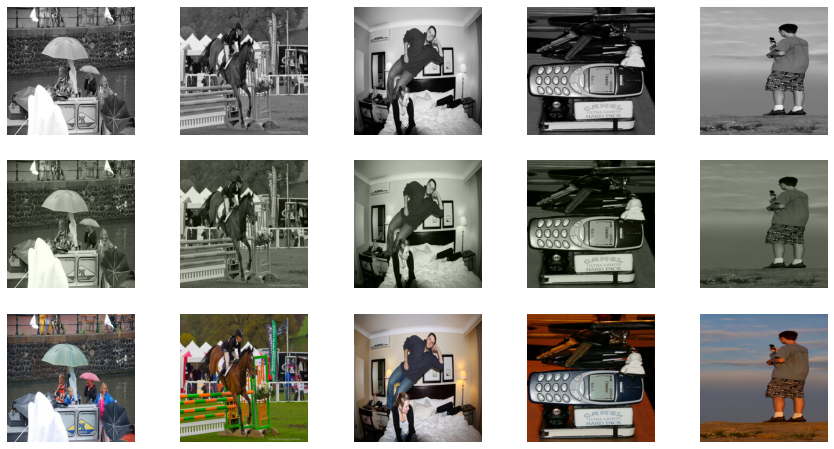


Epoch 1/100
Iteration 10/500
loss_D_fake: 1.02815
loss_D_real: 0.89289
loss_D: 0.96052
loss_G_GAN_PERC: 0.54721
loss_G_GAN_CRIT: 0.92249
loss_G_L1: 10.67411
loss_G: 12.14381


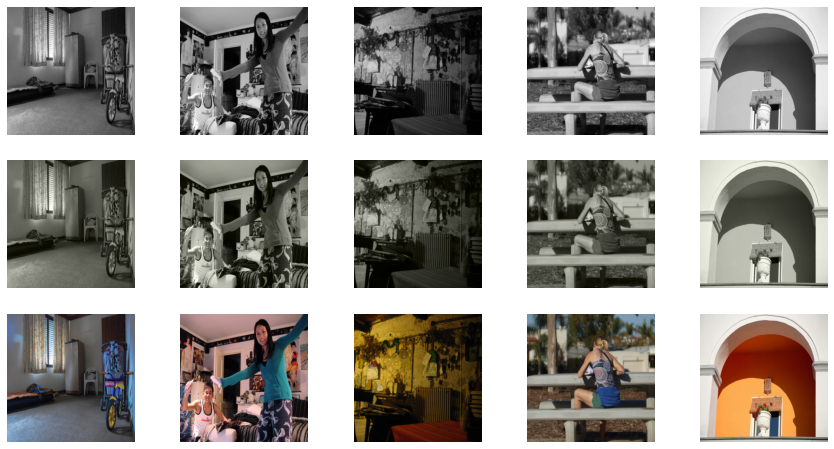


Epoch 1/100
Iteration 15/500
loss_D_fake: 0.91926
loss_D_real: 0.83557
loss_D: 0.87741
loss_G_GAN_PERC: 0.53140
loss_G_GAN_CRIT: 0.86925
loss_G_L1: 9.99472
loss_G: 11.39538


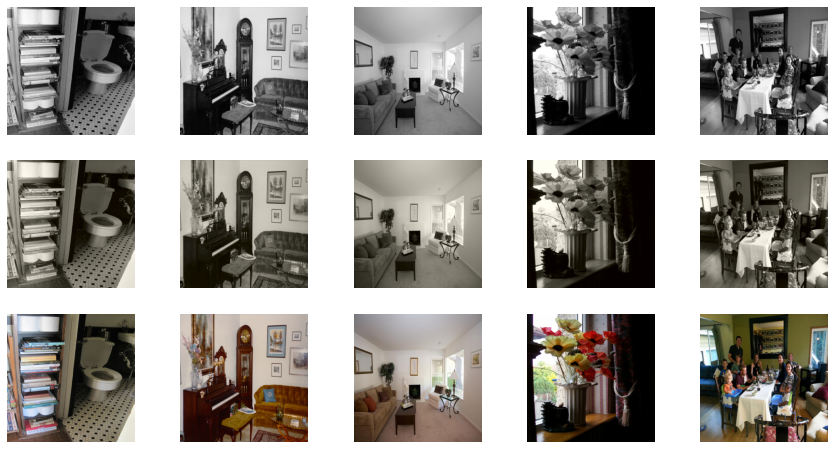


Epoch 1/100
Iteration 20/500
loss_D_fake: 0.85620
loss_D_real: 0.79417
loss_D: 0.82518
loss_G_GAN_PERC: 0.52317
loss_G_GAN_CRIT: 0.85397
loss_G_L1: 9.97709
loss_G: 11.35423


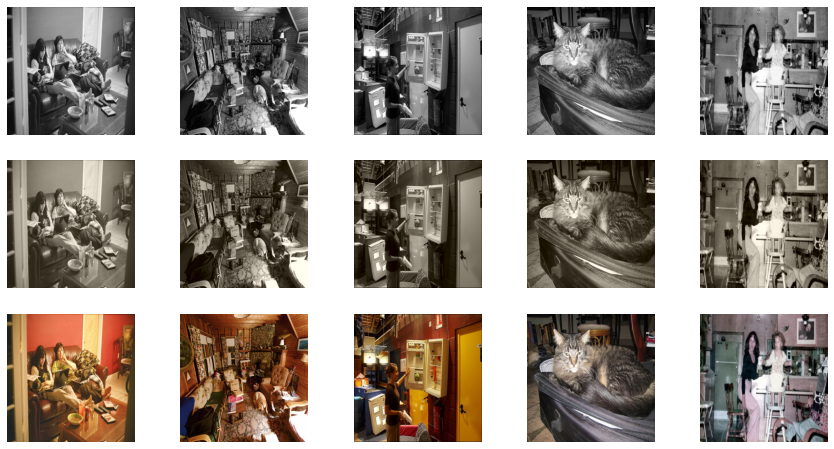

KeyboardInterrupt: ignored

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

path_g = "/content/gdrive/MyDrive/weights/generator.pt"
path_d = "/content/gdrive/MyDrive/weights/discriminator.pt"
path_go = "/content/gdrive/MyDrive/weights/generator_optimizer.pt"
path_do = "/content/gdrive/MyDrive/weights/discriminator_optimizer.pt"
path_losses = '/content/gdrive/MyDrive/weights/losses.txt'

model = MainModel()
train_model(model, train_dataloader, 100, path_g, path_d, path_go, path_do, path_losses)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
model = None
gc.collect()
torch.cuda.empty_cache()
with torch.no_grad():
    torch.cuda.empty_cache()
del model

## PLOT


In [22]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/weights/perceptual80/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1nUx3oz82HYNpCIb_OR5HfPA8F4TKjY_e/weights


In [26]:
def plot_losses(path):
  losses_D = []
  losses_G = []
  epochs = []
  with open(path) as f:
    lines = [line for line in f]
    for ind in range(len(lines)):
      if (ind%8)==0:
        epoch = lines[ind].split(' ')[1]
        epochs.append(epoch)       
        losses_D.append(float(lines[ind+3].split(' ')[1].split('\n')[0]))
        losses_G.append(float(lines[ind+7].split(' ')[1].split('\n')[0]))
        
  ep = list(range(1, len(epochs)+1))
  plt.figure(figsize=(10,5))
  #plt.plot(epochs, losses_G, label="Generator loss")
  print(len(losses_D))
  plt.plot(ep, losses_D, 'b-', label="Discriminator loss")
  plt.figure(figsize=(10,5))
  plt.plot(ep, losses_G, 'r-', label="Discriminator loss")

  plt.figure(figsize=(10,5))
  plt.plot(ep, losses_D, 'b-', label="Discriminator loss")
  plt.plot(ep, losses_G, 'r-', label="Discriminator loss")

  plt.title('Model loss')
  plt.legend()
  plt.show()
  

79


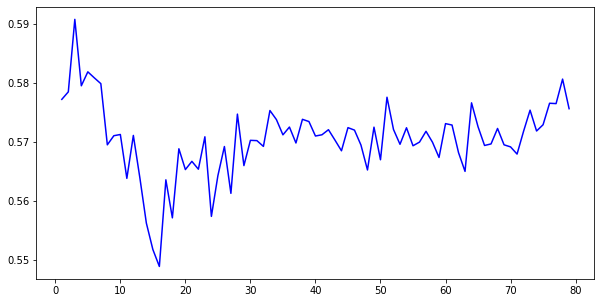

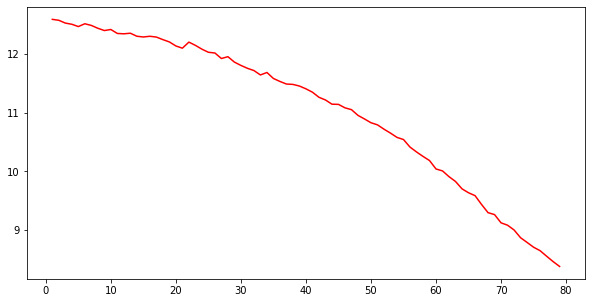

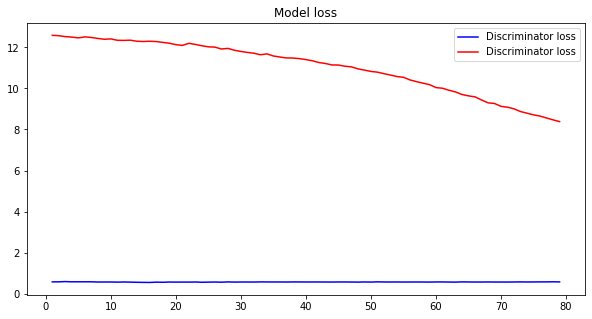

In [27]:
plot_losses('losses.txt')